In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import requests
import pandas as pd
import seaborn as sns


In [ ]:

# fetch vector embedding for a champion
def get_champion_data(version, champ_name):

    # no api key needed
    url = f"https://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/champion/{champ_name}.json"
    data = requests.get(url).json()["data"]
    for champ_name, champ_info in data.items():
        stats = {key: item for key, item in champ_info["stats"].items() if key not in ["crit", "critperlevel"]}
        info = {key: item for key, item in champ_info["info"].items() if key != "difficulty"}
        row = {
            **info,
            **stats
        }
    return list(row.values())
    


In [3]:
champion_vector_mapping = {}
VERSION = "15.23.1"

def get_champion_vector(champ_name):
    if champ_name not in champion_vector_mapping:
        try:
            champion_vector_mapping[champ_name] = get_champion_data(VERSION, champ_name)
        except:
            champion_vector_mapping[champ_name] = [0] * 21
    return champion_vector_mapping[champ_name]

champ_cols = [
    "BLUE_TOP","BLUE_JUNGLE","BLUE_MIDDLE","BLUE_BOTTOM","BLUE_UTILITY",
    "RED_TOP","RED_JUNGLE","RED_MIDDLE","RED_BOTTOM","RED_UTILITY"
]
def row_to_vector(row):
    vectors = []
    for col in champ_cols:
        champ = row[col]
        vectors.extend(get_champion_vector(champ))
    return vectors



In [4]:
len(get_champion_data("15.23.1","Fiddlesticks"))

21

In [5]:
df = pd.read_csv("preprocessed_matches.csv")
X = df.apply(row_to_vector, axis=1, result_type="expand")
y = df["RED_WINNER"].astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (14281, 210)
Target vector shape: (14281,)


In [6]:
X

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,3.0,6.0,8.0,655.0,105.0,150.0,0.0,345.0,36.0,4.7,...,1.80,175.0,7.5,0.85,7.0,0.70,55.0,3.00,2.000,0.625
1,7.0,5.0,7.0,650.0,103.0,339.0,52.0,350.0,36.0,4.2,...,1.30,525.0,5.5,0.55,13.0,0.80,51.0,3.30,2.300,0.625
2,10.0,4.0,2.0,620.0,99.0,300.0,60.0,345.0,33.0,4.7,...,1.30,550.0,7.5,0.75,7.0,0.70,48.0,2.50,3.500,0.625
3,5.0,9.0,3.0,660.0,109.0,341.0,65.0,335.0,33.0,5.2,...,1.30,600.0,3.5,0.55,11.5,0.70,50.0,0.00,2.600,0.625
4,8.0,8.0,7.0,625.0,120.0,320.0,60.0,330.0,36.0,5.2,...,1.30,500.0,5.5,0.55,6.0,0.45,52.0,3.00,2.000,0.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,8.0,6.0,3.0,650.0,99.0,339.0,52.0,340.0,35.0,4.5,...,2.05,125.0,8.5,0.85,8.5,0.80,62.0,3.75,2.125,0.625
14277,10.0,1.0,1.0,550.0,103.0,232.0,35.0,330.0,23.0,4.6,...,1.30,550.0,5.5,0.55,7.5,0.75,54.0,3.30,2.500,0.690
14278,8.0,6.0,3.0,650.0,99.0,339.0,52.0,340.0,35.0,4.5,...,1.55,450.0,7.0,0.55,6.0,0.80,56.0,2.20,3.500,0.625
14279,8.0,4.0,3.0,650.0,114.0,0.0,0.0,345.0,38.0,4.8,...,2.05,125.0,8.5,0.85,6.0,0.80,60.0,3.00,2.900,0.625


In [7]:
y

0        0
1        0
2        1
3        1
4        0
        ..
14276    1
14277    0
14278    0
14279    0
14280    1
Name: RED_WINNER, Length: 14281, dtype: int64

In [8]:
df

,BLUE_TOP,BLUE_JUNGLE,BLUE_MIDDLE,BLUE_BOTTOM,BLUE_UTILITY,RED_WINNER,RED_TOP,RED_JUNGLE,RED_MIDDLE,RED_BOTTOM,RED_UTILITY
0,Rumble,Zyra,Zed,Kaisa,Poppy,False,Yone,Kindred,Cassiopeia,Ziggs,Rell
1,Jax,Syndra,Swain,Twitch,Sion,False,Olaf,Diana,Taliyah,Smolder,Karma
2,Fiora,Trundle,Sylas,Anivia,Poppy,True,Cassiopeia,Nocturne,Hwei,Caitlyn,Neeko
3,Ornn,Viego,Syndra,Ezreal,Leona,True,Cassiopeia,Naafiri,Sylas,Ziggs,Senna
4,KSante,Nocturne,Anivia,Syndra,Alistar,False,Ambessa,Lillia,Ryze,Sivir,Bard
...,...,...,...,...,...,...,...,...,...,...,...
14276,Camille,Gragas,Yasuo,Seraphine,Nautilus,True,Jax,Lillia,Tristana,Samira,Alistar
14277,Vayne,Gragas,Corki,Twitch,Nami,False,Fiora,XinZhao,Sylas,Varus,Hwei
14278,Camille,Elise,Draven,Jinx,Janna,False,Malphite,Khazix,Cassiopeia,Jhin,Thresh
14279,Aatrox,Volibear,Leblanc,Brand,Thresh,False,Kennen,RekSai,Lissandra,MissFortune,Leona


In [9]:
X.isna().sum().sum()

np.int64(0)

In [10]:
df['RED_WINNER'].value_counts()

RED_WINNER
False    7395
True     6886
Name: count, dtype: int64

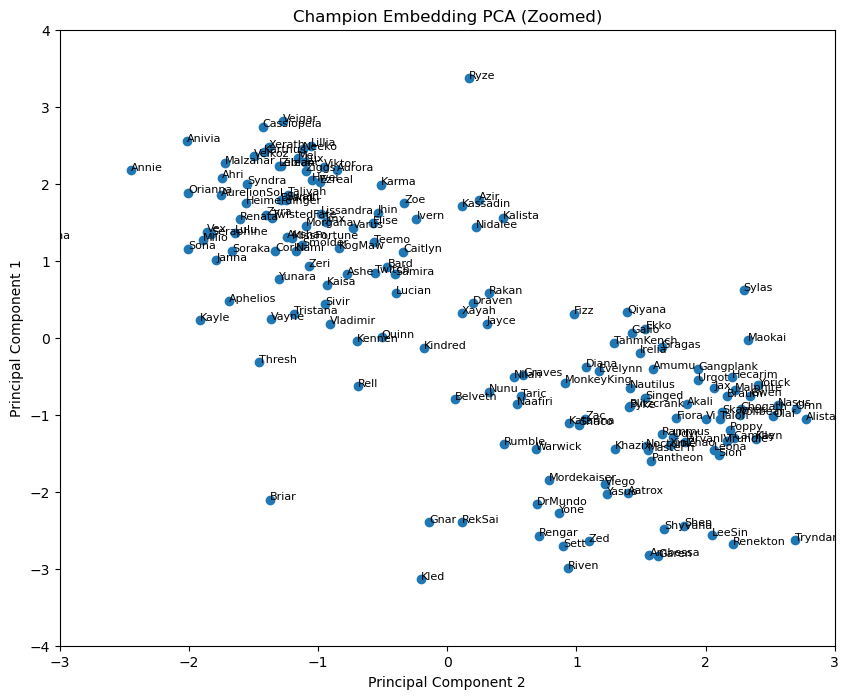

In [ ]:
# pca to understand the data
vecs = np.array(list(champion_vector_mapping.values()))
names = np.array(list(champion_vector_mapping.keys()))

scaler = StandardScaler()
scaled = scaler.fit_transform(vecs)


pca = PCA(n_components=2)
coords = pca.fit_transform(scaled)
plt.figure(figsize=(10,8))

plt.scatter(coords[:,0], coords[:,1])
for name,(x,y_) in zip(names, coords):
    plt.text(x, y_, name, fontsize=8, clip_on=True)


plt.xlim(-3, 3)  
plt.ylim(-4, 4) 
plt.ylabel("Principal Component 1")
plt.xlabel("Principal Component 2")


plt.gca().set_autoscale_on(False)
plt.title("Champion Embedding PCA (Zoomed)")
plt.show()





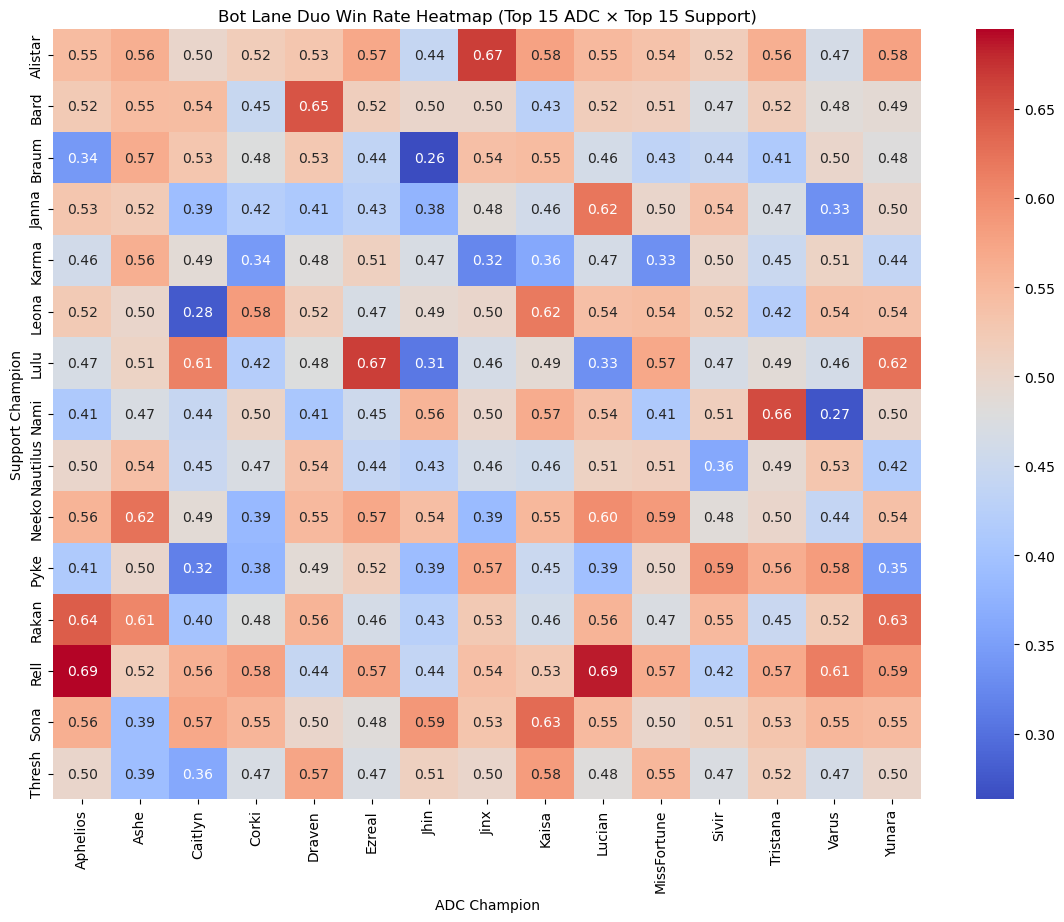

In [ ]:
rows = []

# winrate for combination of ADC + UTILITY pairs out of curiousity

for _, row in df.iterrows():
    rows.append({
        "ADC": row["RED_BOTTOM"],
        "SUPPORT": row["RED_UTILITY"],
        "WIN": row["RED_WINNER"]
    })
    rows.append({
        "ADC": row["BLUE_BOTTOM"],
        "SUPPORT": row["BLUE_UTILITY"],
        "WIN": 1 - row["RED_WINNER"]
    })

bot_sup_pairs = pd.DataFrame(rows)
bot_sup_pairs["WIN"] = bot_sup_pairs["WIN"].astype(float)

adc_counts = bot_sup_pairs["ADC"].value_counts()
sup_counts = bot_sup_pairs["SUPPORT"].value_counts()

top_N_adc = adc_counts.head(15).index
top_N_sup = sup_counts.head(15).index

pivot = bot_sup_pairs.pivot_table(
    index="SUPPORT",
    columns="ADC",
    values="WIN",
    aggfunc="mean"
)

valid_adc = pivot.columns.intersection(top_N_adc)
valid_sup = pivot.index.intersection(top_N_sup)

pivot_small = pivot.loc[valid_sup, valid_adc]

plt.figure(figsize=(14,10))
sns.heatmap(pivot_small, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Bot Lane Duo Win Rate Heatmap (Top 15 ADC × Top 15 Support)")
plt.xlabel("ADC Champion")
plt.ylabel("Support Champion")
plt.show()


In [13]:
scalar = StandardScaler()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
len(y_test)

2857

In [15]:
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(
    gb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

gy_pred = grid.predict(X_test)

print("\nBest parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
print("\nTest accuracy:", accuracy_score(y_test, gy_pred))
print("\nConfusion matrix:")
g_c  = confusion_matrix(y_test, gy_pred)

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV accuracy: 0.5358018207282913

Test accuracy: 0.5250262513125656

Confusion matrix:


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200, 400, 600],  
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid = GridSearchCV(
    rfc,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

ry_pred = grid.predict(X_test)




Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
Best CV accuracy: 0.5340511204481793

Test accuracy: 0.5302765138256913

Confusion matrix:


In [ ]:

print("\nBest parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
print("Accuracy:", accuracy_score(y_test, gy_pred))
print("Precision:", precision_score(y_test, gy_pred, average='weighted'))
print("Recall:", recall_score(y_test, gy_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, gy_pred, average='weighted'))



Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
Best CV accuracy: 0.5340511204481793
Accuracy: 0.5250262513125656
Precision: 0.5221070163563138
Recall: 0.5250262513125656
F1 Score: 0.5146536278816881
ROC-AUC: 0.5279765777488614

Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.67      0.59      1479
           1       0.51      0.37      0.43      1378

    accuracy                           0.53      2857
   macro avg       0.52      0.52      0.51      2857
weighted avg       0.52      0.53      0.51      2857



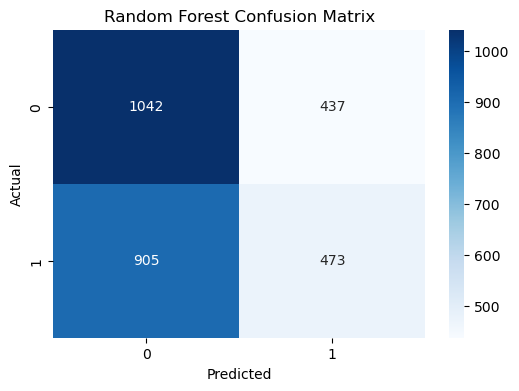

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

r_c = confusion_matrix(y_test, ry_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(r_c, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


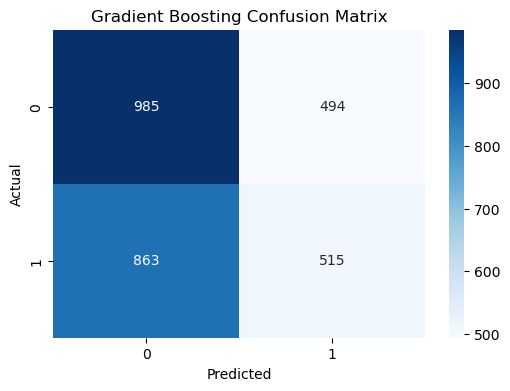

In [22]:

plt.figure(figsize=(6, 4))
sns.heatmap(g_c, annot=True, fmt='d', cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
